Machinery for manufacturing LIBS type spectra

TODO: class docstrings AND Type Hints per:
https://realpython.com/documenting-python-code/
https://docs.python.org/3/library/typing.html

In [99]:
#imports and env
import numpy as np
import pickle
import math
from matplotlib import pyplot as plt
from scipy.special import voigt_profile as voigt
#needed to import our package from sibling directory
import os
import sys
sys.path.insert(0, os.path.abspath('..'))
from libs_unet.training.spec_maker import spectrum_maker
from pathlib import Path

top_dir = Path.cwd().parent #working directory for notebook should be location of notebook
rel_path = 'data' 
datapath = top_dir / rel_path
datafile = "rel_int/valid77_spec.pickle"

In [100]:
#Define the ordered element list for this set of 77
#model training/prediction requires a fixed array structure
with open(datapath / datafile, 'rb') as f:
    raw_atom_dict = pickle.load(f)
#re-order in atomic ordering for convenience, though not contiguous
elem_ordered = np.loadtxt(datapath / "abundance/elements_94.csv", dtype=str)
el_symbol = np.array([])
for el in elem_ordered:
    if el in raw_atom_dict:
        el_symbol = np.append(el_symbol, el)
atom_dict ={}
for el in el_symbol:
    atom_dict[el] = raw_atom_dict[el]
el_count = len(el_symbol)
el_index = {} #lookup from element to index of element
ind = 0
for el in atom_dict.keys():
    el_index[el] = ind
    ind += 1

In [135]:
#create a dataset with fixed proportions on element pairs from 77 elements
spec_maker = spectrum_maker()
n_samples = 8855 #77 pure + 77 choose 2 with 3 mix ratios for each unique pair
fracs = np.zeros((n_samples,el_count)) #these will be intended element mixes for samples
frac_count = 0
#add pure element instances
for i in range(el_count):
    fracs[frac_count,i] = 1
    frac_count += 1
#now add combinations
for i in range(el_count - 1): #Very last element has nothing ahead to pair with
    for j in range(i+1, el_count): #new pairs start at next element and goto last
        fracs[frac_count,i] = 0.9
        fracs[frac_count,j] = 0.1
        frac_count += 1
        fracs[frac_count,i] = 0.5
        fracs[frac_count,j] = 0.5
        frac_count += 1
        fracs[frac_count,i] = 0.1
        fracs[frac_count,j] = 0.9
        frac_count += 1


In [136]:
#construct 8855 sample data set to persist
wave = np.arange(190,950,1) #only needed for correct length
x_data = np.zeros((n_samples, len(wave))) #model inputs, composite spectrum
y_data = np.zeros((n_samples, int(el_count + 2), len(wave))) #desired outputs, weighted spectra

#note the wave range generated from w_lo, w_hi, inc is going to be same in each sample
for i in np.arange(n_samples):
    # create input dict from fracs array
    fracs_dict = {}
    sample_el = el_symbol[np.nonzero(fracs[i])]
    for el in sample_el:
        fracs_dict[el] = fracs[i][el_index[el]]
    wave, spec, spec_dict = spec_maker.make_spectra(fracs_dict, inc=1, w_lo=190, w_hi=950)
    x_data[i] = spec
    for el in spec_dict:
        if el == 'art':
            y_data[i][el_count] = spec_dict[el]
        elif el == 'noi':
            y_data[i][el_count + 1] = spec_dict[el]
        else:
            y_data[i][el_index[el]] = spec_dict[el]

In [137]:
np.sum(y_data[1000][el_index['B']])

0.1

<function matplotlib.pyplot.show(close=None, block=None)>

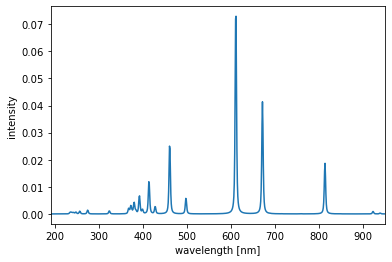

In [138]:
#Inspect combinations / compositions

plt.plot(wave, x_data[el_index['Li']]) 
plt.xlabel('wavelength [nm]')   
plt.ylabel('intensity')
plt.xlim([190, 950]) #note data may go beyond this range
plt.show

In [139]:
#persist sample data and provide code to reload elsewhere
with open(datapath / 'training' / 'el77_pairs.pickle', 'wb') as f:
    pickle.dump(fracs, f)
    pickle.dump(wave, f)
    pickle.dump(x_data, f)
    pickle.dump(y_data, f)
    pickle.dump(el_symbol, f)

#To load in other modules
#with open(datapath / 'training' / 'el77_pairs.pickle', 'rb') as f:
#    fracs = pickle.load(f)
#    wave = pickle.load(f)
#    x_data = pickle.load(f)
#    y_data = pickle.load(f)
#   el_symbol = pickle.load(f)